In [1]:
#LORA CONFIG

rank = 16
alpha = 64

In [2]:
# ## Step 1: Run Training

import torch
import gc
from lora_train import train
from lora_train_dataset import LoRADataset

url = "hf://datasets/huggan/few-shot-obama/data/train-00000-of-00001.parquet"
ds = LoRADataset(url)

print(f"Success! Loaded {len(ds)} images.")

print(f"Image shape: {ds[0].shape}")


#train(LR = 1e-4, BATCH_SIZE=4, EPOCHS = 800, rank=rank, alpha=alpha)


gc.collect()
torch.cuda.empty_cache()

print("Training finished and memory cleared. Ready for inference.")

Loading dataset from hf://datasets/huggan/few-shot-obama/data/train-00000-of-00001.parquet...


/opt/python/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Success! Loaded 100 images.
Image shape: torch.Size([3, 256, 256])
Training finished and memory cleared. Ready for inference.


Loading model from celeba/model.ckpt
Patched config: Removing reference to missing first_stage_model.
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 274.06 M params.
Keeping EMAs of 370.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Training LatentDiffusion as an unconditional model.
trainable params: 1449856 || all params: 275506019 || trainable%: 0.5263
Loading LoRA weights...
LoRA load missing: 368, unexpected: 0
LoRA B mean abs (avg): 0.06729781099420507
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:04<00:00, 11.65it/s]


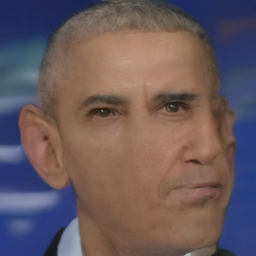

In [3]:
# %%
import torch
import numpy as np
from PIL import Image
from omegaconf import OmegaConf
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from lora import loraModel

# %%
# 1. Configuration
config_path = "configs/latent-diffusion/celebahq-ldm-vq-4.yaml"
ckpt_path = "celeba/model.ckpt"
lora_weights_path = "lora_checkpoints/lora_epoch_350.pt" # Your trained weights
device = "cuda"

# %%
# 2. Load Model
def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")

    # --- THE FIX: Remove the reference to the missing VAE file ---
    if "first_stage_config" in config.model.params:
        if "ckpt_path" in config.model.params.first_stage_config.params:
            print("Patched config: Removing reference to missing first_stage_model.")
            del config.model.params.first_stage_config.params["ckpt_path"]
    # -------------------------------------------------------------

    pl_sd = torch.load(ckpt, map_location="cpu")
    if "state_dict" in pl_sd:
        sd = pl_sd["state_dict"]
    else:
        sd = pl_sd

    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)

    if len(m) > 0 and verbose:
        print("missing keys:", m)
    if len(u) > 0 and verbose:
        print("unexpected keys:", u)

    model.cuda()
    model.eval()
    return model

config = OmegaConf.load(config_path)
model = load_model_from_config(config, ckpt_path)

# %%
# 3. Apply your LoRA
old_unet = model.model.diffusion_model

# !!! INSERT YOUR LORA INJECTION LOGIC HERE !!!

unet = loraModel(old_unet, rank=rank, alpha=alpha, qkv=[True, True, True])
unet.set_trainable_parameters()

# Load your trained LoRA state dict
print("Loading LoRA weights...")
lora_sd = torch.load(lora_weights_path)
missing, unexpected = unet.model.load_state_dict(lora_sd, strict=False)
print(f"LoRA load missing: {len(missing)}, unexpected: {len(unexpected)}")

# quick sanity on LoRA weights
vals = [p.abs().mean().item() for n,p in unet.model.named_parameters() if 'lora_B' in n]
print('LoRA B mean abs (avg):', sum(vals)/len(vals) if vals else None)

model.model.diffusion_model = unet
model.cuda()
# 4. Sampler Setup
sampler = DDIMSampler(model)

# %%
# 5. Generate
# Define parameters
classes = None # Unconditional
n_samples = 1
ddim_steps = 50
ddim_eta = 0.0 # 0 for deterministic, 1 for stochastic
scale = 1.0 # Unconditional guidance scale (doesn't matter much if unconditional)

# Resolution of latents (256px image -> 64x64 latent for f=4 model)
h, w = 256, 256
c = 3
f = 4 # Downsampling factor
shape = [c, h // f, w // f]

with torch.no_grad():
    # Sample from noise
    samples, _ = sampler.sample(
        S=ddim_steps,
        batch_size=n_samples,
        shape=shape,
        eta=ddim_eta,
        verbose=False
    )

    # Decode latents to images
    x_samples_ddim = model.decode_first_stage(samples)

    # Normalize back to [0, 255]
    x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)
    x_samples_ddim = x_samples_ddim.cpu().permute(0, 2, 3, 1).numpy()

    # Convert to image
    x_image_torch = torch.from_numpy(x_samples_ddim).float()
    x_sample = 255. * x_image_torch
    img = x_sample[0].numpy().astype(np.uint8)

    display_img = Image.fromarray(img)
    display_img.save("result_legacy.png")
    display_img.show()

--- Generating Comparison (Seed: 123) ---
1. Sampling with LoRA ENABLED...
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:04<00:00, 12.49it/s]


2. Sampling with LoRA DISABLED (Base Model)...
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:04<00:00, 12.42it/s]


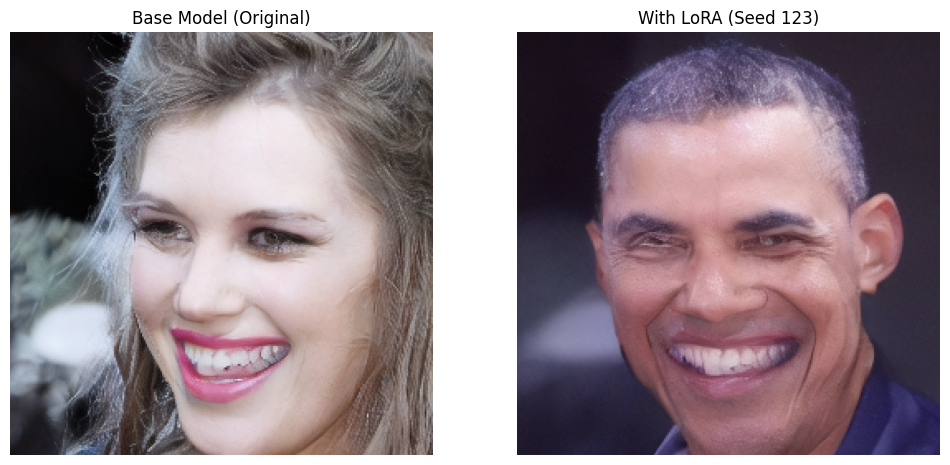

In [4]:
import torch
import numpy as np
from PIL import Image
from einops import rearrange
import matplotlib.pyplot as plt

def generate_comparison(model, sampler, seed=42, steps=50):
    print(f"--- Generating Comparison (Seed: {seed}) ---")

    # 1. Setup Deterministic Noise
    # We create the noise ONCE and pass it to both runs.
    # This ensures the 'randomness' is identical for both.
    generator = torch.Generator(device="cuda").manual_seed(seed)

    # Dimensions for CelebA-HQ 256 (Latent 64x64, 3 channels)
    h, w = 256, 256
    f = 4
    c = 3
    shape = [c, h // f, w // f]

    # Generate the noise tensor on GPU
    # Note: DDIMSampler expects (Batch, Channel, Height, Width)
    x_T = torch.randn((1, *shape), generator=generator, device="cuda")

    # ---------------------------------------------------------
    # RUN 1: LoRA ON
    # ---------------------------------------------------------
    print("1. Sampling with LoRA ENABLED...")

    # LoRA strength relative to original scaling (alpha/rank)
    unet = model.model.diffusion_model

    def set_lora_strength(target_model, strength):
        count = 0
        for module in target_model.modules():
            if hasattr(module, 'scaling'):
                if not hasattr(module, '_original_scaling'):
                    module._original_scaling = module.scaling
                module.scaling = module._original_scaling * strength
                count += 1
        return count

    set_lora_strength(unet, 1.0) # Full LoRA (uses original scaling)

    with torch.no_grad():
        samples_lora, _ = sampler.sample(
            S=steps,
            batch_size=1,
            shape=shape,
            x_T=x_T, # <--- CRITICAL: Pass the fixed noise here
            eta=0.0,
            verbose=False
        )

    # ---------------------------------------------------------
    # RUN 2: LoRA OFF (Base Model)
    # ---------------------------------------------------------
    print("2. Sampling with LoRA DISABLED (Base Model)...")

    # Temporarily set scaling to 0.0 to mute the LoRA layers
    found_layers = set_lora_strength(unet, 0.0)
    if found_layers == 0:
        print("WARNING: Could not find LoRA layers to disable! Comparison might be invalid.")

    with torch.no_grad():
        samples_base, _ = sampler.sample(
            S=steps,
            batch_size=1,
            shape=shape,
            x_T=x_T, # <--- CRITICAL: Reuse the EXACT SAME noise
            eta=0.0,
            verbose=False
        )

    # Restore scaling to 1.0 for future runs
    set_lora_strength(unet, 1.0)

    # ---------------------------------------------------------
    # Decode and Display
    # ---------------------------------------------------------
    def decode_img(samples):
        x_decoded = model.decode_first_stage(samples)
        x_decoded = torch.clamp((x_decoded + 1.0) / 2.0, min=0.0, max=1.0)
        x_decoded = x_decoded.cpu().permute(0, 2, 3, 1).numpy()
        return (255. * x_decoded[0]).astype(np.uint8)

    img_lora = decode_img(samples_lora)
    img_base = decode_img(samples_base)

    # Plot Side by Side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(img_base)
    ax[0].set_title("Base Model (Original)")
    ax[0].axis('off')

    ax[1].imshow(img_lora)
    ax[1].set_title(f"With LoRA (Seed {seed})")
    ax[1].axis('off')

    plt.show()

# Run the comparison
generate_comparison(model, sampler, seed=123)

Loading model from celeba/model.ckpt
Patched config: Removing reference to missing first_stage_model.
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 274.06 M params.
Keeping EMAs of 370.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Training LatentDiffusion as an unconditional model.
trainable params: 1449856 || all params: 275506019 || trainable%: 0.5263
Loading LoRA weights...
LoRA load missing: 368, unexpected: 0
LoRA B Matrices: 128 total
Zero-Initialized: 0 (Should be 0 if loaded correctly!)
Updated LoRA strength to 0.0 for 16 layers.
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|██████████| 100/100 [00:08<00:00, 12.40it/s]


Updated LoRA strength to 0.25 for 16 layers.
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|██████████| 100/100 [00:08<00:00, 12.38it/s]


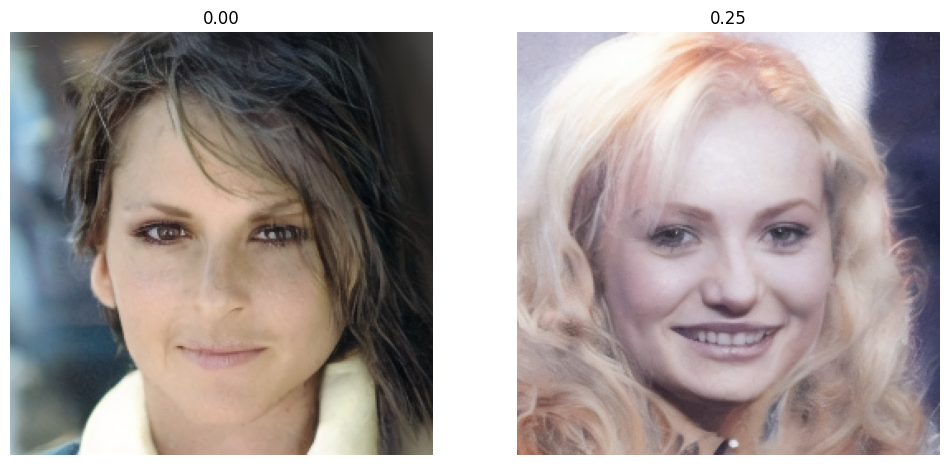

In [5]:
# Run this AFTER you have loaded the model and attached the LoRA

def set_lora_strength(model, strength):
    """
    Manually updates the scaling factor of all LoRA layers.
    strength = 1.0 -> Full LoRA
    strength = 0.5 -> Half strength
    strength = 0.0 -> Original Model
    """
    unet = model.model.diffusion_model
    count = 0

    for module in unet.modules():
        if hasattr(module, "scaling"):
            # Store original scaling if not already stored
            if not hasattr(module, "_original_scaling"):
                module._original_scaling = module.scaling

            # Scale the original value
            module.scaling = module._original_scaling * strength
            count += 1

    print(f"Updated LoRA strength to {strength} for {count} layers.")

# --- TRY THIS ---
# 1. Configuration
config_path = "configs/latent-diffusion/celebahq-ldm-vq-4.yaml"
ckpt_path = "celeba/model.ckpt"
lora_weights_path = "lora_checkpoints/lora_epoch_300.pt" # Your trained weights
device = "cuda"

# %%
# 2. Load Model
def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")

    # --- THE FIX: Remove the reference to the missing VAE file ---
    if "first_stage_config" in config.model.params:
        if "ckpt_path" in config.model.params.first_stage_config.params:
            print("Patched config: Removing reference to missing first_stage_model.")
            del config.model.params.first_stage_config.params["ckpt_path"]
    # -------------------------------------------------------------

    pl_sd = torch.load(ckpt, map_location="cpu")
    if "state_dict" in pl_sd:
        sd = pl_sd["state_dict"]
    else:
        sd = pl_sd

    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)

    if len(m) > 0 and verbose:
        print("missing keys:", m)
    if len(u) > 0 and verbose:
        print("unexpected keys:", u)

    model.cuda()
    model.eval()
    return model

config = OmegaConf.load(config_path)
model = load_model_from_config(config, ckpt_path)

# %%
# 3. Apply your LoRA
unet = model.model.diffusion_model

# !!! INSERT YOUR LORA INJECTION LOGIC HERE !!!

unet = loraModel(unet, rank=rank, alpha=alpha, qkv=[True, True, True])
unet.set_trainable_parameters()
model.model.diffusion_model = unet

# Load your trained LoRA state dict
# You might need to filter keys if you saved the whole UNet
print("Loading LoRA weights...")
lora_sd = torch.load(lora_weights_path)
missing, unexpected = unet.model.load_state_dict(lora_sd, strict=False)
print(f"LoRA load missing: {len(missing)}, unexpected: {len(unexpected)}")


# Check if LoRA weights are actually non-zero
def check_lora_weights(model):
    zeros = 0
    total = 0
    for name, param in model.named_parameters():
        if "lora_B" in name:
            total += 1
            if torch.all(param == 0):
                zeros += 1

    print(f"LoRA B Matrices: {total} total")
    print(f"Zero-Initialized: {zeros} (Should be 0 if loaded correctly!)")

    if zeros == total and total > 0:
        print("❌ CRITICAL: Your LoRA weights are all zero. The load_state_dict failed.")
        print("   Solution: Print the keys in lora_sd and model.state_dict() to compare them.")

check_lora_weights(unet)


model.model.diffusion_model = unet
model.cuda()
# 4. Sampler Setup
sampler = DDIMSampler(model)
# 1. Reduce strength to 0.5 or 0.2 to see if distortion disappears
def decode_img(samples):
        x_decoded = model.decode_first_stage(samples)
        x_decoded = torch.clamp((x_decoded + 1.0) / 2.0, min=0.0, max=1.0)
        x_decoded = x_decoded.cpu().permute(0, 2, 3, 1).numpy()
        return (255. * x_decoded[0]).astype(np.uint8)

N = 10
img_lora = []
# 2. Run your sampler code again
with torch.no_grad():

  for i in range(2):#N):
    set_lora_strength(model, strength=i/4)
    samples, _ = sampler.sample(S=100, batch_size=1, shape=shape, eta=0.0, verbose=False)
    # ... decode and show image ...

    img_lora.append( decode_img(samples) )

    # Plot Side by Side

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i in range(2):#N):
  ax[i].imshow(img_lora[i])
  ax[i].set_title(f"{(i/4):.2f}")
  ax[i].axis('off')

plt.show()


In [6]:
import torch
import torch.nn as nn
from typing import Callable, Tuple, Optional, Dict
import numpy as np
from tqdm import tqdm


class GaussianProbabilityPath:
    """
    Represents a Gaussian probability path with time-dependent noise schedule.
    
    Implements path: q(x_t | x_1) = N(α_t x_1, σ_t^2 I)
    """
    
    def __init__(self, alpha_fn: Callable, sigma_fn: Callable):
        """
        Args:
            alpha_fn: Function mapping t -> α_t (scaling factor)
            sigma_fn: Function mapping t -> σ_t (noise level)
        """
        self.alpha_fn = alpha_fn
        self.sigma_fn = sigma_fn
    
    def alpha(self, t: float) -> float:
        """Get α_t at time t"""
        return self.alpha_fn(t)
    
    def sigma(self, t: float) -> float:
        """Get σ_t at time t"""
        return self.sigma_fn(t)
    
    def r_t_squared(self, t: float) -> float:
        """
        Compute r_t^2 from Eq. (13) and paper derivation:
        r_t^2 = σ_t^2 / (σ_t^2 + α_t^2)
        """
        alpha_t = self.alpha(t)
        sigma_t = self.sigma(t)
        return (sigma_t ** 2) / (sigma_t ** 2 + alpha_t ** 2)
    
    def d_log_alpha_sigma_dt(self, t: float, eps: float = 1e-5) -> float:
        """
        Compute d ln(α_t / σ_t) / dt using finite differences
        
        This is needed for Theorem 1's correction term
        """
        log_ratio_plus = np.log(self.alpha(t + eps) / self.sigma(t + eps))
        log_ratio = np.log(self.alpha(t) / self.sigma(t))
        return (log_ratio_plus - log_ratio) / eps


class ConditionalOTFlowSolver(nn.Module):
    """
    Solves linear inverse problems via flows using conditional OT probability path.
    """
    
    def __init__(
        self,
        denoiser: Callable,
        measurement_matrix: torch.Tensor,
        probability_path: GaussianProbabilityPath,
        sigma_y: float = 0.0,
        gamma_t: float = 1.0,
        device: str = 'cpu',
        use_jvp: bool = False,  # Set to False by default since autograd often fails
        n_hutchinson_samples: int = 10  # Number of samples for Hutchinson estimator
    ):
        """
        Args:
            denoiser: Pretrained denoiser model
            measurement_matrix: Measurement matrix A
            probability_path: GaussianProbabilityPath defining the noise schedule
            sigma_y: Standard deviation of measurement noise
            gamma_t: Adaptive weight for likelihood correction
            device: Device to run computations on
            use_jvp: Whether to try autograd (often fails with pretrained models)
            n_hutchinson_samples: Number of random samples for Hutchinson estimator
        """
        super().__init__()
        
        # Wrap denoiser if it's not a module
        if not isinstance(denoiser, nn.Module):
            class FunctionWrapper(nn.Module):
                def __init__(self, fn):
                    super().__init__()
                    self.fn = fn
                def forward(self, *args, **kwargs):
                    return self.fn(*args, **kwargs)
            self.denoiser = FunctionWrapper(denoiser)
        else:
            self.denoiser = denoiser
            
        self.register_buffer('A', measurement_matrix)
        self.probability_path = probability_path
        self.sigma_y = sigma_y
        self.gamma_t = gamma_t
        self.device = device
        self.use_jvp = use_jvp
        self.n_hutchinson_samples = n_hutchinson_samples
        
        # Precompute A^T A for efficiency
        self.register_buffer('ATA', self.A.T @ self.A)
        self.register_buffer('AAT', self.A @ self.A.T)
        
    def initialize_xt(
        self,
        y: torch.Tensor,
        t: float,
        shape: Tuple[int, ...]
    ) -> torch.Tensor:
        """Initialize x_t in signal space"""
        y = y.to(self.device)
        epsilon = torch.randn(shape, device=self.device, dtype=self.A.dtype)
        
        n_signal = int(np.prod(shape))
        A_pinv = torch.linalg.pinv(self.A)
        y_lifted = A_pinv @ y
        y_lifted = y_lifted.reshape(shape)
        
        z_t = self.probability_path.alpha(t) * y_lifted + self.probability_path.sigma(t) * epsilon
        return z_t
    
    def compute_r_t_squared(self, t_prime: float) -> float:
        """Compute r_t'^2 from the probability path"""
        return self.probability_path.r_t_squared(t_prime)
    
    def convert_to_vector_field(
        self,
        z_t: torch.Tensor,
        t_prime: float,
        x_pred: torch.Tensor
    ) -> torch.Tensor:
        """Convert denoiser prediction to vector field"""
        if t_prime >= 1.0:
            return torch.zeros_like(z_t)
        v_hat = (x_pred - z_t) / (1 - t_prime)
        return v_hat
    
    def _flatten_and_unflatten(self, x: torch.Tensor) -> Tuple[torch.Tensor, Tuple[int, ...]]:
        """Flatten a tensor to 1D and return the original shape"""
        original_shape = x.shape
        flattened = x.reshape(-1)
        return flattened, original_shape
    
    def _compute_grad_via_jvp(
        self,
        z_t: torch.Tensor,
        t_idx,
        vector: torch.Tensor,
        original_shape: Tuple[int, ...]
    ) -> torch.Tensor:
        """
        Compute J^T @ vector using reverse-mode autodiff (VJP).
        """
        is_module = isinstance(self.denoiser, nn.Module)
        was_training = None
        if is_module:
            was_training = self.denoiser.training
            self.denoiser.train()
        
        z_t_copy = z_t.clone().detach().requires_grad_(True)
        
        try:
            x_pred = self.denoiser(z_t_copy.unsqueeze(0), t_idx).squeeze(0)
            
            if not x_pred.requires_grad:
                raise RuntimeError("Denoiser doesn't support gradients")
            
            x_pred_flat = x_pred.reshape(-1)
            
            grad = torch.autograd.grad(
                outputs=x_pred_flat,
                inputs=z_t_copy,
                grad_outputs=vector,
                create_graph=False,
                retain_graph=False
            )[0]
            
            if is_module:
                self.denoiser.train(was_training)
            
            return grad
            
        except Exception as e:
            if is_module:
                self.denoiser.train(was_training)
            print(f"Autograd failed: {e}, falling back to Hutchinson estimator...")
            return self._compute_grad_via_hutchinson(z_t, t_idx, vector, original_shape)
    
    def _compute_grad_via_hutchinson(
        self,
        z_t: torch.Tensor,
        t_idx,
        vector: torch.Tensor,
        original_shape: Tuple[int, ...],
        n_samples: Optional[int] = None
    ) -> torch.Tensor:
        """
        Compute J^T @ vector using Hutchinson's estimator (randomized approximation).
        
        Much more memory efficient than full Jacobian!
        Only requires n_samples forward passes instead of n.
        """
        if n_samples is None:
            n_samples = self.n_hutchinson_samples
            
        z_t_flat = z_t.reshape(-1)
        n = z_t_flat.shape[0]
        
        # Get baseline prediction
        with torch.no_grad():
            x_pred_base = self.denoiser(z_t.unsqueeze(0), t_idx).squeeze(0)
            x_pred_base_flat = x_pred_base.reshape(-1)
        
        # Hutchinson estimator: use random projections
        grad_estimate = torch.zeros_like(z_t_flat)
        eps = 1e-4
        
        for _ in range(n_samples):
            # Random direction (Rademacher: +1 or -1)
            v = torch.randint(0, 2, (n,), device=self.device, dtype=z_t.dtype) * 2 - 1
            
            # Perturb in random direction
            z_perturbed = (z_t_flat + eps * v).reshape(original_shape)
            
            with torch.no_grad():
                x_pred_perturbed = self.denoiser(z_perturbed.unsqueeze(0), t_idx).squeeze(0)
                x_pred_perturbed_flat = x_pred_perturbed.reshape(-1)
            
            # Finite difference
            diff = (x_pred_perturbed_flat - x_pred_base_flat) / eps
            
            # Accumulate gradient estimate
            grad_estimate += v * torch.dot(diff, vector)
        
        # Average over samples
        grad_estimate = grad_estimate / n_samples
        
        return grad_estimate.reshape(original_shape)
    
    def compute_likelihood_gradient(
        self,
        y: torch.Tensor,
        x_pred: torch.Tensor,
        z_t: torch.Tensor,
        t_prime: float,
        idx,
        r_t_squared: float,
        jacobian: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        Compute the likelihood gradient ∇_{x_t} ln q^app(y | x_t) from Theorem 1.
        """
        y = y.to(self.device)
        x_pred_flat, original_shape = self._flatten_and_unflatten(x_pred)
        z_t_flat, _ = self._flatten_and_unflatten(z_t)
        
        # Residual: y - A x̂_1
        residual = y - self.A @ x_pred_flat
        
        # Covariance matrix
        m = self.A.shape[0]
        covariance = (
            r_t_squared * self.AAT +
            (self.sigma_y ** 2) * torch.eye(m, device=self.device, dtype=self.A.dtype)
        )
        
        # Solve linear system
        inv_cov_residual = torch.linalg.solve(covariance, residual)
        grad_in_measurement_space = self.A.T @ inv_cov_residual
        
        # Compute Jacobian if not provided
        if jacobian is None:
            if self.use_jvp:
                # Try autograd first (will fall back to Hutchinson if fails)
                grad_likelihood = self._compute_grad_via_jvp(
                    z_t, idx, grad_in_measurement_space, original_shape
                )
            else:
                # Use Hutchinson estimator directly
                grad_likelihood = self._compute_grad_via_hutchinson(
                    z_t, idx, grad_in_measurement_space, original_shape
                )
        else:
            grad_likelihood = jacobian.T @ grad_in_measurement_space
            grad_likelihood = grad_likelihood.reshape(original_shape)
        
        return grad_likelihood
    
    def correct_vector_field_theorem1(
        self,
        v_hat: torch.Tensor,
        likelihood_grad: torch.Tensor,
        t_prime: float
    ) -> torch.Tensor:
        """Apply Theorem 1 correction to the unconditional vector field"""
        sigma_t = self.probability_path.sigma(t_prime)
        d_log_ratio_dt = self.probability_path.d_log_alpha_sigma_dt(t_prime)
        
        correction = (sigma_t ** 2) * d_log_ratio_dt * self.gamma_t * likelihood_grad
        v_corrected = v_hat + correction
        
        return v_corrected
    
    def forward(
        self,
        y: torch.Tensor,
        signal_shape: Tuple[int, ...],
        t_start: float = 0.5,
        n_steps: int = 100,
        use_likelihood_correction: bool = True
    ) -> torch.Tensor:
        """
        Solve the linear inverse problem by integrating the ODE.
        """
        # Initialize x_t with specified shape
        z_t = self.initialize_xt(y, t_start, signal_shape)
        
        # Time steps for ODE integration from t_start to 1
        t_steps = torch.linspace(t_start, 1.0, n_steps, device=self.device)
        
        # ODE integration loop
        pbar = tqdm(range(len(t_steps) - 1))
        for i in pbar:
            t_prime = float(t_steps[i])
            dt = float(t_steps[i + 1] - t_steps[i])
            
            # Compute r_t'^2 from probability path
            r_t_squared = self.compute_r_t_squared(t_prime)
            
            # Denoiser prediction
            with torch.no_grad():
                x_pred = self.denoiser(z_t.unsqueeze(0), i).squeeze(0)
            
            # Convert to unconditional vector field
            v_hat = self.convert_to_vector_field(z_t, t_prime, x_pred)
            
            # Apply Theorem 1 correction
            if use_likelihood_correction and t_prime > 1e-6:
                likelihood_grad = self.compute_likelihood_gradient(
                    y, x_pred, z_t, t_prime, i, r_t_squared
                )
                v_corrected = self.correct_vector_field_theorem1(
                    v_hat, likelihood_grad, t_prime
                )
            else:
                v_corrected = v_hat
            
            # Euler step for ODE integration
            z_t = (z_t + v_corrected * dt).detach()
            
            # Free memory periodically
            if i % 10 == 0:
                torch.cuda.empty_cache()
        
        return z_t


In [ ]:

#SCEGLI la PP che preferisci (non ho capito veramente la differenza)


# Probability path implementations
class VarianceExplodingPath(GaussianProbabilityPath):
    """
    Variance-Exploding (VE) probability path from DDPM/Song edef denoiser(x, t):
    # Convert t to a proper tensor on the same device as x
    if isinstance(t, int):
        t_tensor = torch.full((x.shape[0],), t, device=x.device, dtype=torch.long)
    else:
        t_tensor = torch.tensor([t], device=x.device, dtype=torch.long)
    
    return model.p_sample(x, None, t_tensor)[0]t al.
    
    α_t = sqrt(1 / (1 + t^2))
    σ_t = t / sqrt(1 + t^2)
    """
    
    def __init__(self):
        def alpha_fn(t):
            return np.sqrt(1.0 / (1.0 + t ** 2))
        
        def sigma_fn(t):
            return t / np.sqrt(1.0 + t ** 2)
        
        super().__init__(alpha_fn, sigma_fn)


class VariancePreservingPath(GaussianProbabilityPath):
    """
    Variance-Preserving (VP) probability path.
    
    α_t = exp(-0.5 * ∫_0^t β(s) ds)
    σ_t = sqrt(1 - α_t^2)
    """
    
    def __init__(self, beta_max: float = 20.0, beta_min: float = 0.1):
        def alpha_fn(t):
            # Linear schedule for beta
            beta_t = beta_min + t * (beta_max - beta_min)
            # Cumulative integral: ∫_0^t β(s) ds ≈ beta_min*t + 0.5*(beta_max-beta_min)*t^2
            integral = beta_min * t + 0.5 * (beta_max - beta_min) * t ** 2
            return np.exp(-0.5 * integral)
        
        def sigma_fn(t):
            alpha_t = alpha_fn(t)
            return np.sqrt(1.0 - alpha_t ** 2)
        
        super().__init__(alpha_fn, sigma_fn)

probability_path = VarianceExplodingPath

totdim = 3*64*64
measdim = 64*64
A = torch.rand(measdim,totdim,device=device)

test = (torch.from_numpy(img_lora[1]).float() / 255.0)
test = test.permute(2, 0, 1).unsqueeze(0).to(device)
testencoded = model.encode_first_stage(test)[0]

measurement = A@testencoded.reshape(-1)


class DenoiserWrapper(nn.Module):
    """Wrapper to make a denoiser function behave like a nn.Module"""
    def __init__(self, denoiser_fn, model=None):
        super().__init__()
        self.denoiser_fn = denoiser_fn
        self.model = model  # Store the actual model if available
        
    def forward(self, x, t):
        return self.denoiser_fn(x, t)
    
    def train(self, mode=True):
        """Set training mode for the underlying model if available"""
        if self.model is not None and isinstance(self.model, nn.Module):
            self.model.train(mode)
        return super().train(mode)
    
    def eval(self):
        """Set eval mode for the underlying model if available"""
        if self.model is not None and isinstance(self.model, nn.Module):
            self.model.eval()
        return super().eval()

def denoiser(x, t):
    # Convert t to a proper tensor on the same device as x
    if isinstance(t, int):
        t_tensor = torch.full((x.shape[0],), t, device=x.device, dtype=torch.long)
    else:
        t_tensor = torch.tensor([t], device=x.device, dtype=torch.long)
    
    return model.p_sample(x, None, t_tensor)[0]


# Wrap it
wrapped_denoiser = DenoiserWrapper(denoiser, model=model)

# Create solver with wrapped denoiser
solver = ConditionalOTFlowSolver(
    denoiser=wrapped_denoiser,  # Use wrapped version
    measurement_matrix=A,
    probability_path=probability_path,
    sigma_y=0.01,
    use_jvp=True,
    device='cuda'
)



prob_path = VarianceExplodingPath()
# Create solver
solver = ConditionalOTFlowSolver(
    denoiser=denoiser,
    measurement_matrix=A,
    probability_path=prob_path,
    sigma_y=0.01,
    gamma_t=1.0,
    device='cuda'
)



signal_shape_3d = (3,64,64)
x_reconstructed_3d = solver(measurement, signal_shape=signal_shape_3d, t_start=0.5, n_steps=model.num_timesteps//2)


 12%|█▏        | 59/499 [01:00<07:27,  1.02s/it]

In [ ]:
torch.cuda.empty_cache()